In [7]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import random

In [8]:
from sqlalchemy import create_engine, text

def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine

In [9]:
# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()

In [10]:
# misc db parameters
url= 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database= 'musiclab'
port= '5432'

In [11]:
data_query = '''
Select *
from adds_temp.ebw_metric_analysis as ema
'''

In [12]:
engine = postgresql_engine(username, password, url, port, database)
with engine.connect() as conn:
    with conn.begin():
        df_ebw_metrics = pd.read_sql(data_query, con=conn)

In [13]:
len(df_ebw_metrics)

2355814

In [14]:
df_ebw_metrics.drop_duplicates(inplace=True)

In [15]:
df_ebw_metrics.head()

,week_dt,mediabase_id,song_id,call_letters,format_code,song_release_date,last_callout_date,first_spin_date,StartDate,EndDate,...,gcr,gcr_adj,station_id,cmm_station_calls,test_date,breakout_respondents,pop,fav_metric,ddl_metric,f2b_ratio
0,2018-10-01,2356990,290730733,KQBT-FM,U1,2018-10-01,2019-06-03,2018-10-08,2018-09-30,2018-10-06,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
1,2018-10-01,2356990,290730733,KRRL-FM,U1,2018-10-01,2018-11-05,2018-10-08,2018-09-30,2018-10-06,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2,2018-10-01,2356990,290730733,WGCI-FM,U1,2018-10-01,2019-03-18,2018-10-08,2018-09-30,2018-10-06,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
3,2018-10-01,2356990,290730733,WJLB-FM,U1,2018-10-01,2020-03-09,2018-10-08,2018-09-30,2018-10-06,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
4,2018-10-01,2356990,290730733,WMIB-FM,U1,2018-10-01,2019-01-14,2018-10-08,2018-09-30,2018-10-06,...,None,None,3322924.0,WMIB-FM,2018-10-01,90.0,73.0,20.0,6.0,3.33


In [16]:
# song-artist lookup
song_query = '''
Select mediabase_id, song_name, artist_name
from data.songs_v as sv
'''
engine = postgresql_engine(username, password, url, port, database)
with engine.connect() as conn:
    with conn.begin():
        df_song_lookup = pd.read_sql(song_query, con=conn)

In [17]:
df_song_lookup.set_index(['mediabase_id'], inplace=True)

In [18]:
df_song_lookup.head()

,song_name,artist_name
mediabase_id,,
1906303,Be Mine,JESSICA BREANNE/ELEC. HEARTS
1178830,Thorazine Shuffle,GOV'T MULE
1929876,Caviar And Meths,JUDAS PRIEST
1786173,Wish You Were Here,AVRIL LAVIGNE
1636575,Sing My Way Home,DELANEY & BONNIE & FRIENDS


In [19]:
# extract all formats
all_formats = list(pd.unique(df_ebw_metrics['format_code']))
all_formats.sort()
all_formats

['A1', 'A2', 'C1', 'H1', 'L1', 'L3', 'O1', 'R1', 'R2', 'R3', 'U1', 'U2', 'Y0']

In [20]:
# define major formats
major_formats = ['C1', 'H1', 'U1']

#### Unique songs

In [21]:
df_ebw_metrics.groupby(['format_code']).apply(lambda x:(len(pd.unique(x['mediabase_id'])), len(pd.unique(x['station_id']))))

format_code
A1     (92, 10)
A2     (272, 9)
C1    (273, 19)
H1    (453, 33)
L1     (263, 5)
L3      (87, 3)
O1      (29, 2)
R1     (160, 2)
R2     (128, 6)
R3     (253, 9)
U1    (500, 17)
U2     (133, 4)
Y0     (366, 7)
dtype: object

#### Unique songs and stations

In [22]:
df_ebw_metrics.groupby(['format_code']).apply(lambda x:len((x[['mediabase_id', 'station_id']].drop_duplicates())))

format_code
A1     490
A2    1149
C1    3409
H1    7260
L1     818
L3     229
O1      58
R1     319
R2     496
R3     969
U1    3126
U2     417
Y0    1390
dtype: int64

### Calculated fields for analysis

In [23]:
# Look at two appearances in top quintile of callout research
df_pop_quintile = pd.DataFrame(df_ebw_metrics[~pd.isna(df_ebw_metrics['pop'])].groupby(['format_code', 'cmm_station_calls', 'week_dt']).apply(lambda x: np.quantile(x['pop'], 0.80)), columns=['top_quintile_cutoff'])

In [24]:
df_pop_quintile

top_quintile_cutoff
format_code cmm_station_calls week_dt                        
A1          KDGE-FM           2019-06-10                 67.0
                              2019-07-08                 80.2
                              2019-07-22                 79.4
                              2019-08-05                 93.0
                              2019-08-19                 77.4
...                                                       ...
Y0          WJMN-FM           2022-08-08                 86.0
                              2022-08-22                 90.4
                              2022-08-29                 94.2
                              2022-09-12                 90.0
                              2022-09-26                 92.8

[7862 rows x 1 columns]

In [25]:
df_ebw_metrics['is_top_quintile'] = df_ebw_metrics.join(df_pop_quintile, on=['format_code', 'cmm_station_calls', 'week_dt'], rsuffix='_r').apply(lambda x: int(x['pop'] >= x['top_quintile_cutoff']), axis=1)

In [26]:
df_ebw_metrics['week_dt'] = pd.to_datetime(df_ebw_metrics['week_dt'])

In [27]:
df_ebw_metrics.sort_values(by=['format_code', 'call_letters', 'mediabase_id', 'week_dt'], inplace=True)

In [28]:
df_ebw_metrics['spins_non_on_prev'] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])['spins_non_on'].shift(1)

In [29]:
df_ebw_metrics['cuml_spins_non_on'] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])['spins_non_on'].cumsum()

In [30]:
df_ebw_metrics['num_top_quintile'] = df_ebw_metrics[df_ebw_metrics['cuml_spins_non_on'] >= 50].groupby(['format_code', 'call_letters', 'mediabase_id'])['is_top_quintile'].cumsum()

In [31]:
100*(int(np.max(df_ebw_metrics['cuml_spins_non_on'])/100) + 1)

7400

In [32]:
df_ebw_metrics['cuml_spins_bucket'] = pd.cut(df_ebw_metrics['cuml_spins_non_on'], bins=pd.interval_range(start=0, end=100*(int(np.max(df_ebw_metrics['cuml_spins_non_on'])/100) + 1), freq=100))

In [33]:
df_ebw_metrics['weeks_since_release'] = ((df_ebw_metrics['week_dt'] - pd.to_datetime(df_ebw_metrics['song_release_date']))/np.timedelta64(1, 'W')).apply(int)

In [34]:
df_ebw_metrics['propn_market_spins'] = df_ebw_metrics['spins_non_on']/df_ebw_metrics['MarketSpinsToDate']

In [35]:
df_ebw_metrics = df_ebw_metrics.join(df_song_lookup, on=['mediabase_id'])

In [36]:
ddl_range = np.arange(10, 26, 1)
f2b_range = np.arange(0.85, 1.55, 0.05)

In [37]:
ddl_geq_cols = ['ddl_geq_' + str(int(i)) for i in ddl_range]
ddl_track_cols = ['ddl_track_' + str(int(i)) for i in ddl_range]

f2b_leq_cols = ['f2b_leq_' + '%.2f'%i for i in f2b_range]
f2b_track_cols = ['f2b_track_' + '%.2f'%i  for i in f2b_range]

In [38]:
for i in range(len(ddl_range)):
    df_ebw_metrics[ddl_geq_cols[i]] = df_ebw_metrics['ddl_metric'].apply(lambda x: int(x >= ddl_range[i]))
    df_ebw_metrics[ddl_track_cols[i]] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])[ddl_geq_cols[i]].cumsum()

for i in range(len(f2b_range)):
    df_ebw_metrics[f2b_leq_cols[i]] = df_ebw_metrics['f2b_ratio'].apply(lambda x: int(x <= f2b_range[i]))
    df_ebw_metrics[f2b_track_cols[i]] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])[f2b_leq_cols[i]].cumsum()

In [39]:
df_ebw_metrics[df_ebw_metrics['f2b_track_1.00'] >= 2].groupby(['format_code', 'call_letters', 'mediabase_id']).agg({'week_dt':np.min, 'cuml_spins_non_on': np.min, 'weeks_since_release': np.min})

week_dt  cuml_spins_non_on  \
format_code call_letters mediabase_id                                 
A1          KDGE-FM      2436510      2021-03-08                  3   
                         2461348      2021-03-08                 50   
                         2475394      2021-02-22                931   
                         2502821      2021-02-08                  0   
                         2506820      2020-06-08                 50   
...                                          ...                ...   
Y0          WJMN-FM      2744465      2021-12-06                210   
                         2744718      2022-02-07                327   
                         2745318      2022-01-10                227   
                         2746130      2022-01-10                259   
                         2753540      2022-03-14                332   

                                       weeks_since_release  
format_code call_letters mediabase_id                       
A1          KDGE-FM      2436510                       127  
                         2461348                       113  
                         2475394                       103  
                         2502821                        88  
                         2506820                        53  
...                                                    ...  
Y0          WJMN-FM      2744465                        13  
                         2744718                        22  
                         2745318                        18  
                         2746130                        18  
                         2753540                        36  

[3415 rows x 3 columns]

In [40]:
df_ebw_metrics[(df_ebw_metrics['mediabase_id']==2436510) & (df_ebw_metrics['call_letters'] == 'KIIS-FM')].head(100)

,week_dt,mediabase_id,song_id,call_letters,format_code,song_release_date,last_callout_date,first_spin_date,StartDate,EndDate,...,f2b_leq_1.30,f2b_track_1.30,f2b_leq_1.35,f2b_track_1.35,f2b_leq_1.40,f2b_track_1.40,f2b_leq_1.45,f2b_track_1.45,f2b_leq_1.50,f2b_track_1.50
127,2018-10-01,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-09-30,2018-10-06,...,0,0,0,0,0,0,0,0,0,0
791,2018-10-08,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-07,2018-10-13,...,0,0,0,0,0,0,0,0,0,0
1455,2018-10-15,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-14,2018-10-20,...,0,0,0,0,0,0,0,0,0,0
2119,2018-10-22,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-21,2018-10-27,...,0,0,0,0,0,0,0,0,0,0
2783,2018-10-29,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-28,2018-11-03,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549733,2020-07-27,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2020-07-26,2020-08-01,...,0,3,0,3,0,5,0,7,0,9
560971,2020-08-03,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,NaT,NaT,...,0,3,0,3,0,5,0,7,0,9
572591,2020-08-10,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,NaT,NaT,...,0,3,0,3,0,5,0,7,0,9
584211,2020-08-17,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2020-08-16,2020-08-22,...,0,3,0,3,0,5,0,7,0,9


### Analyze Favorite, DDL and F2B ratio

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set_theme(style='white')

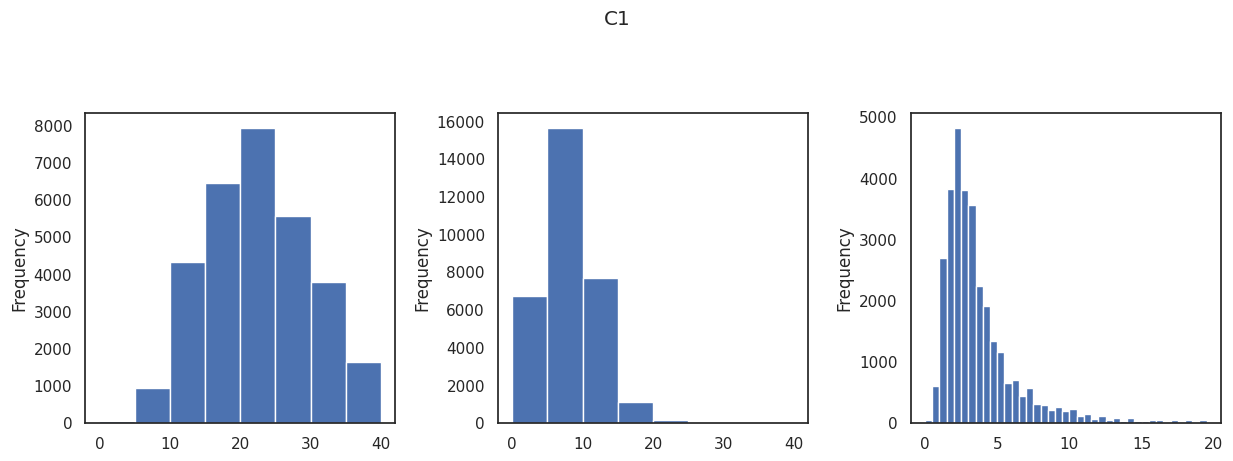

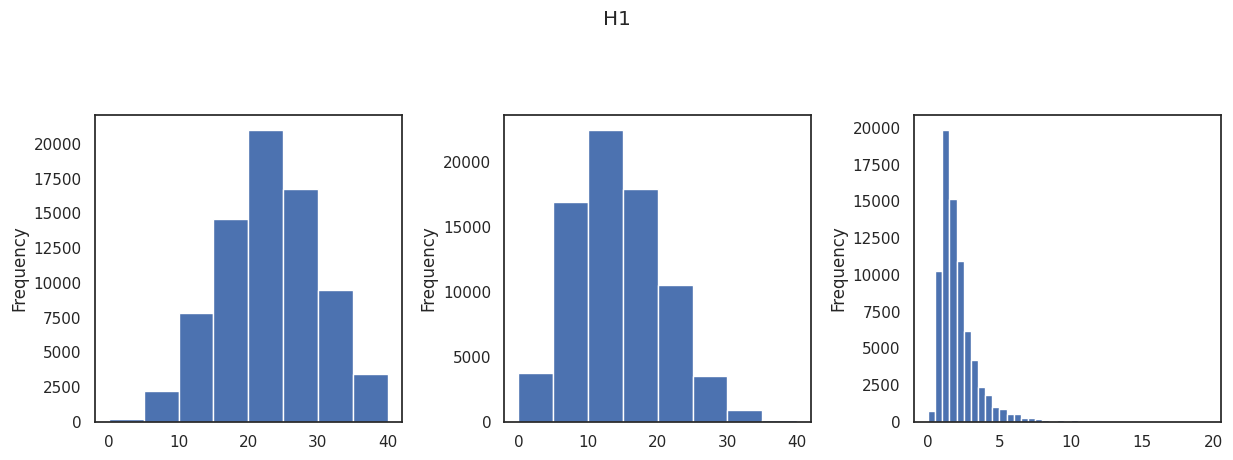

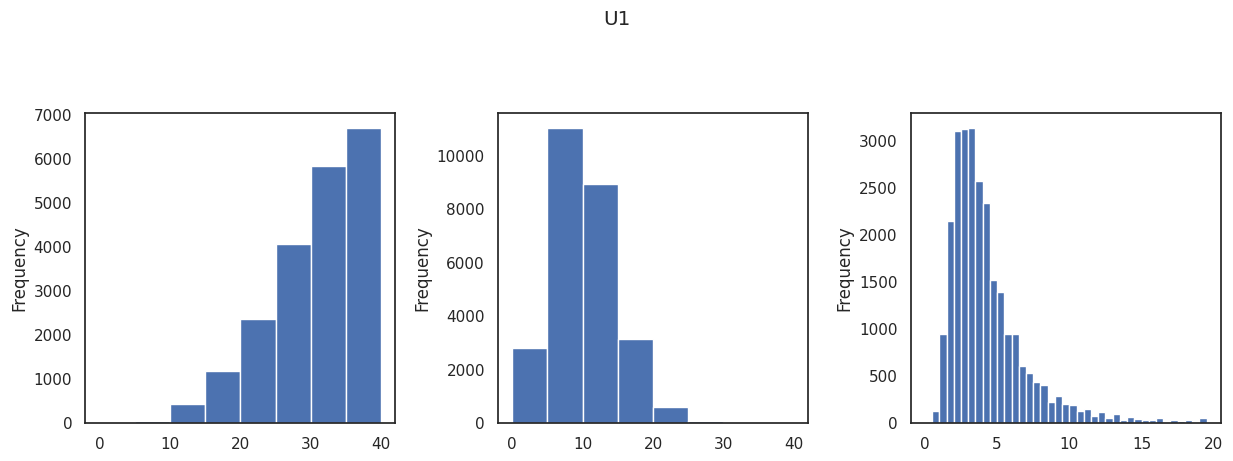

In [35]:
# Look a distribution of DDL and F2b for major formats
for fmt in major_formats:
    idx = (df_ebw_metrics['format_code']==fmt) & (~pd.isna(df_ebw_metrics['pop']))
    fig = plt.figure(figsize=(12.5, 5))
    ax1= plt.subplot(1,3,1)
    df_ebw_metrics[idx]['fav_metric'].plot(ax=ax1, kind='hist', bins=np.arange(0,45,5))

    ax2= plt.subplot(1,3,2)
    df_ebw_metrics[idx]['ddl_metric'].plot(ax=ax2, kind='hist', bins=np.arange(0,45,5))

    ax3=plt.subplot(1,3,3)
    df_ebw_metrics[idx]['f2b_ratio'].plot(ax=ax3, kind='hist', bins=np.arange(0,20,0.5))

    ax1.set_aspect(1/ax1.get_data_ratio())
    ax2.set_aspect(1/ax2.get_data_ratio())
    ax3.set_aspect(1/ax3.get_data_ratio())

    plt.suptitle(fmt)
    fig.tight_layout()
    plt.show()

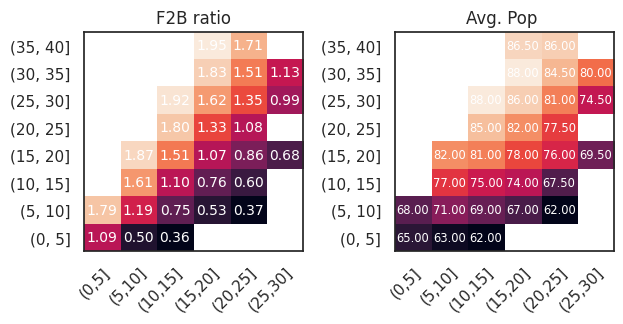

In [36]:
# plot out favorite, f2b ratio, and pop scoress
for fmt in major_formats:
    df_temp = df_ebw_metrics[(df_ebw_metrics['format_code']==fmt) & (~pd.isna(df_ebw_metrics['pop'])) & (df_ebw_metrics['f2b_ratio']<=2)]

    # Discretize DDL and F2B
    df_temp.loc[:, 'fav_bucket'] = pd.cut(df_temp['fav_metric'], bins=pd.interval_range(start=0, end=40, freq=5))
    df_temp.loc[:, 'ddl_bucket'] = pd.cut(df_temp['ddl_metric'], bins=pd.interval_range(start=0, end=40, freq=5))

    df_temp_agg_f2b = pd.pivot_table(df_temp.groupby(['ddl_bucket', 'fav_bucket']).agg({'f2b_ratio': np.mean}).reset_index(), index = ['fav_bucket'], columns=['ddl_bucket'])
    df_temp_agg_pop = pd.pivot_table(df_temp.groupby(['ddl_bucket', 'fav_bucket']).agg({'pop': np.median}).reset_index(), index = ['fav_bucket'], columns=['ddl_bucket'])

    # print(df_temp_agg_f2b)
    ax1 = plt.subplot(1,2,1)
    im = ax1.imshow(df_temp_agg_f2b, origin='lower')

    # Show all ticks and label them with the respective list entries
    ax1.set_yticks(ticks=np.arange(len(df_temp_agg_f2b.index)), labels=df_temp_agg_f2b.index)
    ax1.set_xticks(ticks=np.arange(len( df_temp_agg_f2b.columns)), labels=['(' + str(i.left) + ',' +  str(i.right) + ']' for (j,i) in df_temp_agg_f2b.columns])
    #
    # # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #
    # # Loop over data dimensions and create text annotations.
    for i in np.arange(len(df_temp_agg_f2b.columns)):
        for j in np.arange(len(df_temp_agg_f2b.index)):
            text = ax1.text(i, j, "%.2f"%df_temp_agg_f2b.iloc[j, i],
                           ha="center", va="center", color="w", fontsize='small')

    ax1.set_title("F2B ratio")
    ax1.set_aspect(1/ax1.get_data_ratio())
    ax1.grid(False)

    # plot pop
    ax2 = plt.subplot(1,2,2)
    im = ax2.imshow(df_temp_agg_pop, origin='lower')

    # Show all ticks and label them with the respective list entries
    ax2.set_yticks(ticks=np.arange(len(df_temp_agg_pop.index)), labels=df_temp_agg_pop.index)
    ax2.set_xticks(ticks=np.arange(len( df_temp_agg_pop.columns)), labels=['(' + str(i.left) + ',' +  str(i.right) + ']' for (j,i) in df_temp_agg_pop.columns])
    #
    # # Rotate the tick labels and set their alignment.
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #
    # # Loop over data dimensions and create text annotations.
    for i in np.arange(len(df_temp_agg_pop.columns)):
        for j in np.arange(len(df_temp_agg_pop.index)):
            text = ax2.text(i, j, "%.2f"%df_temp_agg_pop.iloc[j, i],
                           ha="center", va="center", color="w", fontsize = 'x-small')

    ax2.set_title("Avg. Pop ")
    ax2.set_aspect(1/ax2.get_data_ratio())
    ax2.grid(False)

    plt.tight_layout()
    break

### What does burnout look like?

In [37]:
# explore songs suggested by Marc
artists = ['WALKER HAYES', 'SAM HUNT', 'GABBY BARRETT']
idx = (df_ebw_metrics['artist_name'].isin(artists)) & (df_ebw_metrics['weeks_since_release'] <= 104)
df_ebw_metrics[idx].groupby (['mediabase_id', 'song_name', 'artist_name']).agg({'cuml_spins_non_on': np.max, 'song_release_date': np.min}).reset_index().sort_values(by=['artist_name', 'cuml_spins_non_on'], ascending=False)

,mediabase_id,song_name,artist_name,cuml_spins_non_on,song_release_date
6,2706913,Fancy Like,WALKER HAYES,2009,2021-06-01
1,2496571,Don't Let Her,WALKER HAYES,211,2019-05-01
4,2569833,Hard To Forget,SAM HUNT,2116,2020-02-01
3,2537662,Kinfolks,SAM HUNT,2066,2019-10-01
5,2585510,Breaking Up Was Easy In The...,SAM HUNT,2024,2020-04-01
7,2739937,23,SAM HUNT,1902,2021-09-01
0,2466281,I Hope f/Charlie Puth,GABBY BARRETT,2610,2019-01-01
2,2512461,The Good Ones,GABBY BARRETT,1404,2019-07-01


In [38]:
songs_sample = ['Fancy Like', 'Hard To Forget', 'Kinfolks', 'Breaking Up Was Easy In The...', '23', 'The Good Ones', 'I Hope f/Charlie Puth']

In [39]:
# idx = (df_ebw_metrics['ddl_track_15'] >= 2) & (df_ebw_metrics['format_code'] == 'C1') & (df_ebw_metrics['song_name'].isin(songs_sample))
idx = (df_ebw_metrics['f2b_track_1.15'] >= 2) & (df_ebw_metrics['format_code'] == 'C1') & (df_ebw_metrics['song_name'].isin(songs_sample))
df_brn_temp = df_ebw_metrics.loc[idx].groupby(['format_code', 'call_letters', 'mediabase_id']).agg({'week_dt': np.min})

In [40]:
df_brn_instances = df_ebw_metrics.join(df_brn_temp, on=['format_code', 'call_letters', 'mediabase_id'], how='inner', rsuffix='_r')[['mediabase_id', 'call_letters', 'week_dt', 'song_name', 'artist_name', 'pop', 'ddl_metric', 'fav_metric', 'f2b_ratio', 'spins_non_on', 'cuml_spins_non_on', 'MarketSpinsToDate', 'stream_count', 'propn_market_spins']]

In [41]:
song_artist_pairs = [(i,j) for (i,j) in list(df_brn_instances[['mediabase_id', 'call_letters']].drop_duplicates().values)]

In [42]:
len(song_artist_pairs)

10

In [43]:
import os
# Inspect Data for Gabby Barrett (I Hope f/Charlie Puth)
for i in song_artist_pairs:
    fig = plt.gcf()
    fig.set_size_inches(9,9)
    ax = plt.subplot(2,2,1)
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0])].set_index(['week_dt'])['spins_non_on'].rolling(2).mean().plot(ax=ax, marker='^', color='orange')

    # df_brn_instances[(df_brn_instances['call_letters'] == 'WPGB-FM') & (df_brn_instances['mediabase_id'] == 2466281)].set_index(['week_dt'])['stream_count']plot(ax=ax, marker='^', color='orange')
    ax1=ax.twinx()
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0]) & (~pd.isna(df_brn_instances['pop']))].set_index(['week_dt'])['f2b_ratio'].plot(ax=ax1, marker='o')
    ax1.set_ylim([0, 5])
    plt.legend(['weekly spins', 'DDL'])

    ax = plt.subplot(2,2,2)
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0])].set_index(['week_dt'])['propn_market_spins'].rolling(1).mean().plot(ax=ax, marker='^', color='orange')

    ax1=ax.twinx()
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0]) & (~pd.isna(df_brn_instances['pop']))].set_index(['week_dt'])['ddl_metric'].plot(ax=ax1, marker='o')
    ax1.set_ylim([0, 5])
    plt.legend(['market spins', 'DDL'])

    ax = plt.subplot(2,2,3)
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0])].set_index(['week_dt'])['stream_count'].rolling(1).mean().plot(ax=ax, marker='^', color='orange')

    ax1=ax.twinx()
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0]) & (~pd.isna(df_brn_instances['pop']))].set_index(['week_dt'])['f2b_ratio'].plot(ax=ax1, marker='o')
    ax1.set_ylim([0, 5])
    plt.legend(['stream count', 'DDL'])

    ax = plt.subplot(2,2,4)
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0]) & (~pd.isna(df_brn_instances['pop']))].set_index(['week_dt'])['pop'].rolling(1).mean().plot(ax=ax, marker='^', color='orange', label='POP')

    ax1=ax.twinx()
    df_brn_instances[(df_brn_instances['call_letters'] == i[1]) & (df_brn_instances['mediabase_id'] == i[0]) & (~pd.isna(df_brn_instances['pop']))].set_index(['week_dt'])['f2b_ratio'].plot(ax=ax1, marker='o', label='DDL')
    ax1.set_ylim([0, 5])
    plt.legend()

    plt.suptitle(df_ebw_metrics[df_ebw_metrics['mediabase_id'] == i[0]]['song_name'].drop_duplicates().iloc[0] + ' (' + df_ebw_metrics[df_ebw_metrics['mediabase_id'] == i[0]]['artist_name'].drop_duplicates().iloc[0] + ') @ ' + i[1])
    plt.tight_layout()
    plt.savefig(os.getcwd() + '/img/' + df_ebw_metrics[df_ebw_metrics['mediabase_id'] == i[0]]['song_name'].drop_duplicates().iloc[0].replace('/', '_') + '_' + df_ebw_metrics[df_ebw_metrics['mediabase_id'] == i[0]]['artist_name'].drop_duplicates().iloc[0] + '_' + i[1] + '_f2b.jpeg', format='jpeg', dpi=300)
    plt.close()

In [42]:
# Plot pop/ddl/fav, f2b, spins(weekly, market), streams

### Analyze candidate population for burnout analysis

In [43]:
df_hits = df_ebw_metrics.join(df_ebw_metrics[df_ebw_metrics['num_top_quintile'] >=2].groupby(['format_code', 'call_letters', 'mediabase_id']).agg({'week_dt': np.min, 'weeks_since_release': np.min, 'cuml_spins_non_on': np.min}), how='right', on = ['format_code', 'call_letters', 'mediabase_id'], rsuffix='_r')

In [44]:
df_hits[['call_letters', 'mediabase_id']].drop_duplicates()

,call_letters,mediabase_id
4284,KDGE-FM,2457068
15129,KDGE-FM,2466281
32636,KDGE-FM,2475394
79270,KDGE-FM,2506820
148457,KDGE-FM,2531558
...,...,...
1169193,WJMN-FM,2720292
1232899,WJMN-FM,2723707
1233041,WJMN-FM,2727194
1382679,WJMN-FM,2739037


In [45]:
df_hits['hit_spins_bucket'] = pd.cut(df_hits['cuml_spins_non_on_r'],bins=pd.interval_range(50, 100*(int(np.max(df_hits['cuml_spins_non_on_r'])/100) + 1), freq=100))

In [46]:
df_hits.groupby(['format_code', 'hit_spins_bucket']).apply(lambda x: len(x[['call_letters', 'mediabase_id']].drop_duplicates()))

format_code  hit_spins_bucket
A1           (50, 150]           22
             (150, 250]          49
             (250, 350]          40
             (350, 450]          21
             (450, 550]          15
                                 ..
Y0           (2250, 2350]         1
             (2350, 2450]         1
             (2750, 2850]         1
             (2950, 3050]         1
             (3150, 3250]         1
Length: 227, dtype: int64

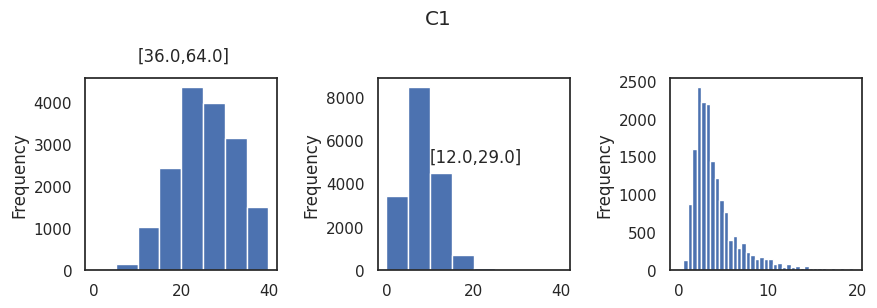

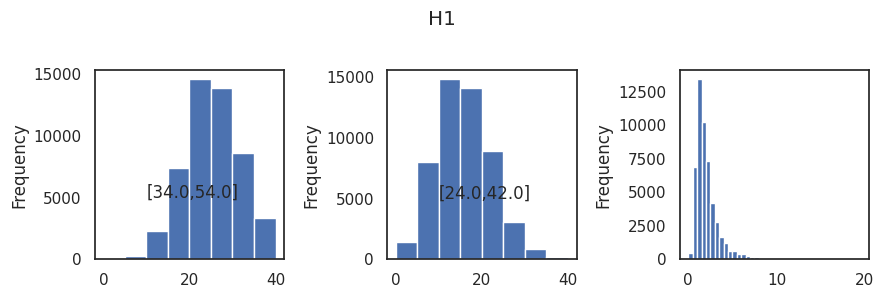

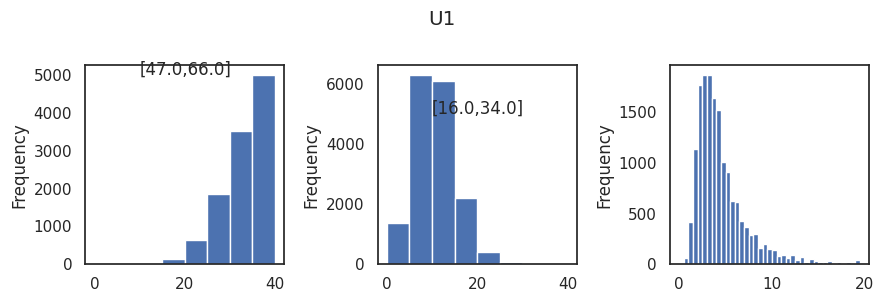

In [47]:
# Look a distribution of DDL and F2b for major formats
for fmt in major_formats:
    idx = (df_hits['format_code']==fmt) & (~pd.isna(df_hits['pop']))
    fig = plt.figure(figsize=(9, 3))
    ax1= plt.subplot(1,3,1)
    df_hits[idx]['fav_metric'].plot(ax=ax1, kind='hist', bins=np.arange(0,45,5))
    ax1.text(y= 5000, x= 10, s='[' + str(np.quantile(df_hits[idx]['fav_metric'], 0.90)) + ',' + str(np.max(df_hits[idx]['fav_metric'])) + ']')

    ax2= plt.subplot(1,3,2)
    df_hits[idx]['ddl_metric'].plot(ax=ax2, kind='hist', bins=np.arange(0,45,5))
    ax2.text(y= 5000, x= 10, s='[' + str(np.quantile(df_hits[idx]['ddl_metric'], 0.90)) + ',' + str(np.max(df_hits[idx]['ddl_metric'])) + ']')

    ax3=plt.subplot(1,3,3)
    df_hits[idx]['f2b_ratio'].plot(ax=ax3, kind='hist', bins=np.arange(0,20,0.5))


    ax1.set_aspect(1/ax1.get_data_ratio())
    ax2.set_aspect(1/ax2.get_data_ratio())
    ax3.set_aspect(1/ax3.get_data_ratio())

    plt.suptitle(fmt)
    fig.tight_layout()
    plt.show()

In [48]:
df_hits_brn = df_hits.join(df_hits[(df_hits['ddl_track_20'] >= 2) & (df_hits['week_dt'] > df_hits['week_dt_r'])].groupby(['format_code', 'call_letters', 'mediabase_id']).agg({'week_dt': np.min, 'weeks_since_release': np.min, 'cuml_spins_non_on':np.min}), how='right', on = ['format_code', 'call_letters', 'mediabase_id'], rsuffix='_brn')

In [49]:
df_hits_brn_f2b = df_hits.join(df_hits[(df_hits['f2b_track_1.00'] >= 2) & (df_hits['week_dt'] > df_hits['week_dt_r'])].groupby(['format_code', 'call_letters', 'mediabase_id']).agg({'week_dt': np.min, 'weeks_since_release': np.min, 'cuml_spins_non_on':np.min}), how='right', on = ['format_code', 'call_letters', 'mediabase_id'], rsuffix='_brn')

In [50]:
df_hits_brn.columns

Index(['week_dt', 'mediabase_id', 'song_id', 'call_letters', 'format_code',
       'song_release_date', 'last_callout_date', 'first_spin_date',
       'StartDate', 'EndDate',
       ...
       'f2b_track_1.45', 'f2b_leq_1.50', 'f2b_track_1.50', 'week_dt_r',
       'weeks_since_release_r', 'cuml_spins_non_on_r', 'hit_spins_bucket',
       'week_dt_brn', 'weeks_since_release_brn', 'cuml_spins_non_on_brn'],
      dtype='object', length=108)

In [51]:
fn1=lambda x: np.mean(x['week_dt_brn'] - x['week_dt_r'])/np.timedelta64(1, 'W')
fn2=lambda x: np.mean(x['cuml_spins_non_on_brn'] - x['cuml_spins_non_on_r'])
fn3=lambda x: len(x[['call_letters', 'mediabase_id']].drop_duplicates())


grp_cols = ['format_code', 'hit_spins_bucket']
pd.DataFrame(df_hits.groupby(grp_cols).apply(fn3), columns=['total_instances']).join(pd.DataFrame(df_hits_brn.groupby(grp_cols).apply(fn3), columns=['bunrout_instance']).join(pd.DataFrame(df_hits_brn.groupby(['format_code', 'hit_spins_bucket']).apply(fn1), columns=['diff_weeks']).join(pd.DataFrame(df_hits_brn.groupby(['format_code', 'hit_spins_bucket']).apply(fn2), columns=['diff_spins']), rsuffix='_r')))

total_instances  bunrout_instance  diff_weeks  \
format_code hit_spins_bucket                                                  
A1          (50, 150]                      22               NaN         NaN   
            (150, 250]                     49               5.0   62.016018   
            (250, 350]                     40               4.0   38.663093   
            (350, 450]                     21               1.0    1.000000   
            (450, 550]                     15               3.0   27.245614   
...                                       ...               ...         ...   
Y0          (2250, 2350]                    1               NaN         NaN   
            (2350, 2450]                    1               1.0    8.000000   
            (2750, 2850]                    1               NaN         NaN   
            (2950, 3050]                    1               1.0    2.000000   
            (3150, 3250]                    1               1.0    1.000000   

                              diff_spins  
format_code hit_spins_bucket              
A1          (50, 150]                NaN  
            (150, 250]        567.322654  
            (250, 350]        572.826953  
            (350, 450]         12.000000  
            (450, 550]        170.403509  
...                                  ...  
Y0          (2250, 2350]             NaN  
            (2350, 2450]      252.000000  
            (2750, 2850]             NaN  
            (2950, 3050]      172.000000  
            (3150, 3250]       48.000000  

[227 rows x 4 columns]

In [52]:
pd.DataFrame(df_hits.groupby(grp_cols).apply(fn3), columns=['total_instances']).join(pd.DataFrame(df_hits_brn_f2b.groupby(grp_cols).apply(fn3), columns=['bunrout_instance']).join(pd.DataFrame(df_hits_brn_f2b.groupby(['format_code', 'hit_spins_bucket']).apply(fn1), columns=['diff_weeks']).join(pd.DataFrame(df_hits_brn_f2b.groupby(['format_code', 'hit_spins_bucket']).apply(fn2), columns=['diff_spins']), rsuffix='_r')))

total_instances  bunrout_instance  diff_weeks  \
format_code hit_spins_bucket                                                  
A1          (50, 150]                      22               5.0   20.904452   
            (150, 250]                     49              11.0   53.715481   
            (250, 350]                     40               7.0   35.204870   
            (350, 450]                     21               2.0   15.693333   
            (450, 550]                     15               4.0   17.876823   
...                                       ...               ...         ...   
Y0          (2250, 2350]                    1               NaN         NaN   
            (2350, 2450]                    1               NaN         NaN   
            (2750, 2850]                    1               NaN         NaN   
            (2950, 3050]                    1               1.0   25.000000   
            (3150, 3250]                    1               1.0    1.000000   

                              diff_spins  
format_code hit_spins_bucket              
A1          (50, 150]         289.978284  
            (150, 250]        559.779812  
            (250, 350]        450.503778  
            (350, 450]        112.320000  
            (450, 550]        122.379254  
...                                  ...  
Y0          (2250, 2350]             NaN  
            (2350, 2450]             NaN  
            (2750, 2850]             NaN  
            (2950, 3050]      901.000000  
            (3150, 3250]       48.000000  

[227 rows x 4 columns]

### How do we define burnout? (appropriate metric - DDL or F2B)? What is an appropriate threshold for DDL/F2B

In [53]:
from datetime import timedelta

In [54]:
df_all_stats = pd.DataFrame( columns=['spins_non_on_delta_sgn', 'total', 'avg_pop_delta', 'min_pop_delta', 'max_pop_delta', 'avg_fav_delta', 'min_fav_delta', 'max_fav_delta', 'avg_ddl_delta', 'min_ddl_delta', 'max_ddl_delta', 'ddl_threshold'])

for i in ddl_range:
    print(i)
    idx = (df_hits['ddl_track_' + str(int(i))] >= 2) & (df_hits['week_dt'] > df_hits['week_dt_r']) & (df_hits['format_code'] == 'C1')

    df_temp  = df_hits.join(df_hits[idx].groupby(['call_letters' , 'mediabase_id']).agg({'week_dt':np.min}), on=['call_letters', 'mediabase_id'], how='right', rsuffix='_brn')
    filter_idx = (df_temp['week_dt'] >= df_temp['week_dt_brn']) & (df_temp['week_dt'] <=  (df_temp['week_dt_brn']) + timedelta(weeks=26)) & (~pd.isna(df_temp['pop']))
    df_temp_filter = df_temp[filter_idx][['format_code', 'call_letters', 'mediabase_id', 'week_dt', 'spins_non_on', 'spins_non_on_prev', 'pop', 'fav_metric', 'ddl_metric']]

    # Spins Delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['spins_non_on_prev'] - x['spins_non_on_prev'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['spins_non_on_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['spins_non_on_prev'] - x['spins_non_on_prev'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['spins_non_on_delta'] = df_test

    # DDL delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['ddl_metric'] - x['ddl_metric'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['ddl_metric_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['ddl_metric'] - x['ddl_metric'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['ddl_metric_delta'] = df_test

    # Fav delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['fav_metric'] - x['fav_metric'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['fav_metric_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['fav_metric'] - x['fav_metric'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['fav_metric_delta'] = df_test

    # Pop delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['pop'] - x['pop'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['pop_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['pop'] - x['pop'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['pop_delta'] = df_test

    # df_temp_filter['spins_non_on_delta'].plot(kind='hist', bins=np.arange(-60,68,2))
    # plt.show()

    df_out = df_temp_filter.groupby(['spins_non_on_delta_sgn']).agg({'week_dt': len, 'pop_delta':[np.mean, np.min, np.max], 'fav_metric_delta': [np.mean, np.min, np.max], 'ddl_metric_delta': [np.mean, np.min, np.max]}).reset_index()
    df_out.columns = ['spins_non_on_delta_sgn', 'total', 'avg_pop_delta', 'min_pop_delta', 'max_pop_delta', 'avg_fav_delta', 'min_fav_delta', 'max_fav_delta',
                      'avg_ddl_delta', 'min_ddl_delta', 'max_ddl_delta']

    df_out['ddl_threshold'] = int(i)
    df_all_stats =  pd.concat([df_all_stats, df_out])

10
11
12
13
14
15
16
17
18
19
20
21
22
23


IndexError: Too many levels: Index has only 2 levels, not 3

In [ ]:
(df_all_stats.reset_index(drop=True))[['spins_non_on_delta_sgn', 'ddl_threshold', 'total', 'avg_pop_delta', 'avg_fav_delta', 'avg_ddl_delta']]

In [ ]:
df_all_stats['spins_non_on_delta_sgn']

In [ ]:
df_all_stats_f2b = pd.DataFrame( columns=['spins_non_on_delta_sgn', 'total', 'avg_pop_delta', 'min_pop_delta', 'max_pop_delta', 'avg_fav_delta', 'min_fav_delta', 'max_fav_delta', 'avg_ddl_delta', 'min_ddl_delta', 'max_ddl_delta', 'f2b_threshold'])

for i in f2b_range:
    print('%.2f'%i)
    idx = (df_hits['f2b_track_' + '%.2f'%i] >= 2) & (df_hits['week_dt'] > df_hits['week_dt_r']) & (df_hits['format_code'] == 'C1')

    df_temp  = df_hits.join(df_hits[idx].groupby(['call_letters' , 'mediabase_id']).agg({'week_dt':np.min}), on=['call_letters', 'mediabase_id'], how='right', rsuffix='_brn')
    filter_idx = (df_temp['week_dt'] >= df_temp['week_dt_brn']) & (df_temp['week_dt'] <=  (df_temp['week_dt_brn']) + timedelta(weeks=26)) & (~pd.isna(df_temp['pop']))
    df_temp_filter = df_temp[filter_idx][['format_code', 'call_letters', 'mediabase_id', 'week_dt', 'spins_non_on', 'spins_non_on_prev', 'pop', 'fav_metric', 'ddl_metric']]

    # Spins Delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['spins_non_on_prev'] - x['spins_non_on_prev'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['spins_non_on_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['spins_non_on_prev'] - x['spins_non_on_prev'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['spins_non_on_delta'] = df_test

    # DDL delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['ddl_metric'] - x['ddl_metric'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['ddl_metric_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['ddl_metric'] - x['ddl_metric'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['ddl_metric_delta'] = df_test

    # Fav delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['fav_metric'] - x['fav_metric'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['fav_metric_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['fav_metric'] - x['fav_metric'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['fav_metric_delta'] = df_test

    # Pop delta and sign
    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: np.sign(x['pop'] - x['pop'].shift(1))))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['pop_delta_sgn'] = df_test

    df_test = pd.DataFrame(df_temp_filter.groupby(['call_letters' , 'mediabase_id']).apply(lambda x: x['pop'] - x['pop'].shift(1)))
    df_test.set_index(df_test.index.get_level_values(2), inplace=True)
    df_temp_filter['pop_delta'] = df_test

    # df_temp_filter['spins_non_on_delta'].plot(kind='hist', bins=np.arange(-60,68,2))
    # plt.show()

    df_out = df_temp_filter.groupby(['spins_non_on_delta_sgn']).agg({'week_dt': len, 'pop_delta':[np.mean, np.min, np.max], 'fav_metric_delta': [np.mean, np.min, np.max], 'ddl_metric_delta': [np.mean, np.min, np.max]}).reset_index()
    df_out.columns = ['spins_non_on_delta_sgn', 'total', 'avg_pop_delta', 'min_pop_delta', 'max_pop_delta', 'avg_fav_delta', 'min_fav_delta', 'max_fav_delta',
                      'avg_ddl_delta', 'min_ddl_delta', 'max_ddl_delta']

    df_out['f2b_threshold'] = '%.2f'%i
    df_all_stats_f2b =  pd.concat([df_all_stats_f2b, df_out])

In [ ]:
(df_all_stats_f2b.reset_index(drop=True))[['spins_non_on_delta_sgn', 'f2b_threshold', 'total', 'avg_pop_delta', 'avg_fav_delta', 'avg_ddl_delta']]

#### pre-burn vs post burn drop off in pop

In [186]:
df_temp_diff = pd.DataFrame(columns= ['format_code', 'call_letters', 'mediabase_id', 'fav_metric', 'ddl_metric', 'pop', 'metric', 'metric_threshold'])
for i in ddl_range:
    for fmt in major_formats:
        # print(fmt)
        id_cols = ['format_code', 'call_letters', 'mediabase_id']
        idx = (df_hits['ddl_track_' + str(int(i))] >= 2) & (df_hits['week_dt'] > df_hits['week_dt_r']) & (df_hits['format_code'] == fmt)

        df_temp  = df_hits.join(df_hits[idx].groupby(['format_code', 'call_letters' , 'mediabase_id']).agg({'week_dt':np.min}), on=['format_code', 'call_letters', 'mediabase_id'], how='right', rsuffix='_brn')
        filter_idx_post = (df_temp['week_dt'] > df_temp['week_dt_brn']) & (df_temp['week_dt'] <=  (df_temp['week_dt_brn']) + timedelta(weeks=13)) & (~pd.isna(df_temp['pop']))
        df_temp_filter_post = df_temp[filter_idx_post][['format_code', 'call_letters', 'mediabase_id', 'week_dt', 'spins_non_on', 'spins_non_on_prev', 'pop', 'fav_metric', 'ddl_metric']]

        filter_idx_pre = (df_temp['week_dt'] < df_temp['week_dt_brn']) & (df_temp['week_dt'] >=  (df_temp['week_dt_brn']) + timedelta(weeks=-13)) & (~pd.isna(df_temp['pop']))
        df_temp_filter_pre = df_temp[filter_idx_pre][['format_code', 'call_letters', 'mediabase_id', 'week_dt', 'spins_non_on', 'spins_non_on_prev', 'pop', 'fav_metric', 'ddl_metric']]


        temp_diff = pd.DataFrame(df_temp_filter_post.groupby(id_cols).agg({'fav_metric': np.mean, 'ddl_metric':np.mean, 'pop':np.mean}) - df_temp_filter_pre.groupby(id_cols).agg({'fav_metric': np.mean, 'ddl_metric':np.mean, 'pop':np.mean}))
        # print(df_temp_filter_pre.groupby(id_cols).agg({'pop': np.mean}))
        temp_diff.dropna(inplace=True)
        temp_diff.reset_index(inplace=True)
        temp_diff['metric'] = 'ddl'
        temp_diff['metric_threshold'] = str(int(i))

        df_temp_diff = pd.concat([temp_diff, df_temp_diff])

In [185]:
pd.unique(df_temp_diff['format_code'])

array(['U1', 'H1', 'C1'], dtype=object)

In [ ]:
for i in ddl_range:
    if (len(df_temp_diff[df_temp_diff['ddl_threshold'] == i]) >= 50):
        df_temp_diff[df_temp_diff['ddl_threshold'] == i]['fav_metric'].plot(kind='hist', alpha=0.5, bins=np.arange(-20,22, 2), label=str(i))
        # print(np.quantile(df_temp_diff[df_temp_diff['ddl_threshold'] == i]['fav_metric'], 0.25))
        print(i)
        print(sum(df_temp_diff[df_temp_diff['ddl_threshold'] == i]['fav_metric'] < -2) / float(len(df_temp_diff[df_temp_diff['ddl_threshold'] == i]['fav_metric'])))
plt.legend()

In [187]:
df_temp_diff_f2b = pd.DataFrame(columns= ['format_code', 'call_letters', 'mediabase_id', 'fav_metric', 'ddl_metric', 'pop', 'metric', 'metric_threshold'])
for i in f2b_range:
    for fmt in major_formats:
        id_cols = ['format_code', 'call_letters', 'mediabase_id']
        idx = (df_hits['f2b_track_' + '%.2f'%i] >= 2) & (df_hits['week_dt'] > df_hits['week_dt_r']) & (df_hits['format_code'] == fmt)

        df_temp  = df_hits.join(df_hits[idx].groupby(['format_code', 'call_letters' , 'mediabase_id']).agg({'week_dt':np.min}), on=['format_code', 'call_letters', 'mediabase_id'], how='right', rsuffix='_brn')
        filter_idx_post = (df_temp['week_dt'] > df_temp['week_dt_brn']) & (df_temp['week_dt'] <=  (df_temp['week_dt_brn']) + timedelta(weeks=13)) & (~pd.isna(df_temp['pop']))
        df_temp_filter_post = df_temp[filter_idx_post][['format_code', 'call_letters', 'mediabase_id', 'week_dt', 'spins_non_on', 'spins_non_on_prev', 'pop', 'fav_metric', 'ddl_metric']]

        filter_idx_pre = (df_temp['week_dt'] < df_temp['week_dt_brn']) & (df_temp['week_dt'] >=  (df_temp['week_dt_brn']) + timedelta(weeks=-13)) & (~pd.isna(df_temp['pop']))
        df_temp_filter_pre = df_temp[filter_idx_pre][['format_code', 'call_letters', 'mediabase_id', 'week_dt', 'spins_non_on', 'spins_non_on_prev', 'pop', 'fav_metric', 'ddl_metric']]


        temp_diff = pd.DataFrame(df_temp_filter_post.groupby(id_cols).agg({'fav_metric': np.mean, 'ddl_metric':np.mean, 'pop':np.mean}) - df_temp_filter_pre.groupby(id_cols).agg({'fav_metric': np.mean, 'ddl_metric':np.mean, 'pop':np.mean}))
        # print(df_temp_filter_pre.groupby(id_cols).agg({'pop': np.mean}))
        temp_diff.dropna(inplace=True)
        temp_diff.reset_index(inplace=True)
        temp_diff['metric'] = 'f2b'
        temp_diff['metric_threshold'] = '%.2f'%i

        df_temp_diff_f2b = pd.concat([temp_diff, df_temp_diff_f2b])

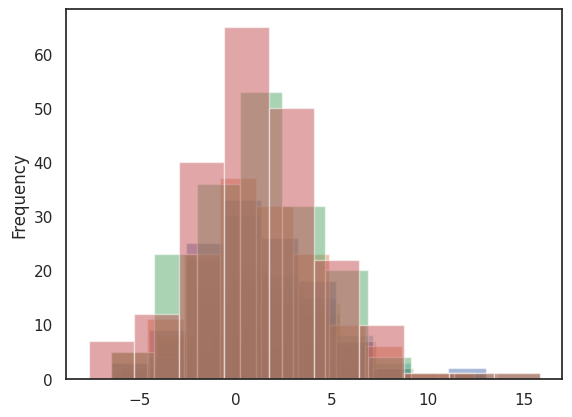

In [87]:
for i in f2b_range:
    df_temp_diff_f2b[df_temp_diff_f2b['f2b_threshold'] == '%.2f'%i]['ddl_metric'].plot(kind='hist', alpha=0.5)

In [188]:
df_diff = pd.concat([df_temp_diff, df_temp_diff_f2b])

In [179]:
pd.unique(df_diff['format_code'])

array(['U1', 'Y0', 'H1', 'C1', 'O1', 'L1'], dtype=object)

In [137]:
df_hits.groupby(['format_code']).apply(lambda x:len(x[['call_letters', 'mediabase_id']].drop_duplicates()))

format_code
A1     173
A2     248
C1    1037
H1    2006
L1     141
L3      60
O1      12
R1      55
R2     105
R3     168
U1     673
U2      41
Y0     263
dtype: int64

In [190]:
df_diff_summ = df_diff.groupby(['format_code', 'metric', 'metric_threshold']).agg({'mediabase_id':len}).join(pd.DataFrame(df_hits[df_hits['format_code'].isin(major_formats)].groupby(['format_code']).apply(lambda x:len(x[['call_letters', 'mediabase_id']].drop_duplicates())), columns=['total_songs']), on = ['format_code'], how='left')

In [191]:
df_diff_summ.columns = ['burnout_songs', 'total_songs']

In [192]:
df_diff_summ['fav_drop_count'] = df_diff.groupby(['format_code', 'metric', 'metric_threshold']).apply(lambda x: sum(x['fav_metric'] < -3))

In [193]:
df_diff_summ['ddl_inc_count'] = df_diff.groupby(['format_code', 'metric', 'metric_threshold']).apply(lambda x: sum(x['ddl_metric'] > 3))

In [194]:
df_diff_summ['pop_drop_count'] = df_diff.groupby(['format_code', 'metric', 'metric_threshold']).apply(lambda x: sum(x['pop'] < -5))

In [197]:
df_diff_summ.reset_index()

,format_code,metric,metric_threshold,burnout_songs,total_songs,fav_drop_count,ddl_inc_count,pop_drop_count,burn_perc,fav_drop_perc,ddl_inc_perc,pop_drop_perc
0,C1,ddl,10,719,1037,139,178,130,0.693346,0.193324,0.247566,0.180807
1,C1,ddl,11,566,1037,114,152,109,0.545805,0.201413,0.268551,0.192580
2,C1,ddl,12,412,1037,87,112,75,0.397300,0.211165,0.271845,0.182039
3,C1,ddl,13,283,1037,73,77,64,0.272903,0.257951,0.272085,0.226148
4,C1,ddl,14,212,1037,56,49,52,0.204436,0.264151,0.231132,0.245283
...,...,...,...,...,...,...,...,...,...,...,...,...
85,U1,f2b,1.30,36,673,8,14,12,0.053492,0.222222,0.388889,0.333333
86,U1,f2b,1.35,38,673,10,13,14,0.056464,0.263158,0.342105,0.368421
87,U1,f2b,1.40,47,673,14,14,16,0.069837,0.297872,0.297872,0.340426
88,U1,f2b,1.45,57,673,18,17,17,0.084695,0.315789,0.298246,0.298246


In [196]:
df_diff_summ['burn_perc'] = df_diff_summ['burnout_songs']/df_diff_summ['total_songs']
df_diff_summ['fav_drop_perc'] = df_diff_summ['fav_drop_count']/df_diff_summ['burnout_songs']
df_diff_summ['ddl_inc_perc'] = df_diff_summ['ddl_inc_count']/df_diff_summ['burnout_songs']
df_diff_summ['pop_drop_perc'] = df_diff_summ['pop_drop_count']/df_diff_summ['burnout_songs']

### Post Burnout Pop Analysis - cool-off period